In [81]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amiangshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/amiangshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('train.csv', sep=',', header=0)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("test_dat.csv")
train_data.to_csv("train_dat.csv")

train_df = pd.read_csv('train_dat.csv', sep=',', header=0)
test_df = pd.read_csv('test_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  6090
Number of testing data:  1523


In [83]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('train.csv', sep=',', header=0)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("test_dat.csv")
train_data.to_csv("train_dat.csv")

train_df = pd.read_csv('train_dat.csv', sep=',', header=0)
test_df = pd.read_csv('test_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  6090
Number of testing data:  1523


/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


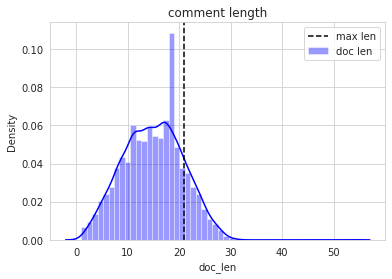

In [84]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [85]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

 24%|██▎       | 1436/6090 [00:00<00:00, 7108.63it/s]

pre-processing train data...


100%|██████████| 1523/1523 [00:00<00:00, 7377.83it/s]


tokenizing input data...
dictionary size:  22247


In [86]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [87]:
from keras.layers import BatchNormalization
import tensorflow as tf
es_callback = EarlyStopping(monitor='val_loss', patience=3)


In [88]:
max_features =50000
nb_words=50000
embedding_dim =16
sequence_length = 100
def lstm_without_embed():
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    #embeddings_regularizer = regularizers.l2(0.005))) 
    model.add(tf.keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len,trainable=False))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add(tf.keras.layers.Dropout(0.4))


    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    return model


In [89]:
lstm_no_embed=lstm_without_embed()
lstm_no_embed.summary()
lstm_no_embed.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 300)           15000000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 16)            20288     
_________________________________________________________________
flatten_1 (Flatten)          (None, 336)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               172544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [90]:
#epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
es_callback = EarlyStopping(monitor='val_loss', patience=3)
lstm_no_embed_history = lstm_no_embed.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3,callbacks=[es_callback], shuffle=False)

Train on 4263 samples, validate on 1827 samples
Epoch 1/40
4263/4263 [==============================] - 1s 334us/sample - loss: 1.5332 - binary_accuracy: 0.5574 - val_loss: 1.3367 - val_binary_accuracy: 0.5594
Epoch 2/40
4263/4263 [==============================] - 0s 106us/sample - loss: 1.2150 - binary_accuracy: 0.5738 - val_loss: 1.0875 - val_binary_accuracy: 0.5594
Epoch 3/40
4263/4263 [==============================] - 1s 118us/sample - loss: 1.0151 - binary_accuracy: 0.5738 - val_loss: 0.9362 - val_binary_accuracy: 0.5594
Epoch 4/40
4263/4263 [==============================] - 0s 107us/sample - loss: 0.8999 - binary_accuracy: 0.5738 - val_loss: 0.8485 - val_binary_accuracy: 0.5594
Epoch 5/40
4263/4263 [==============================] - 1s 128us/sample - loss: 0.8292 - binary_accuracy: 0.5738 - val_loss: 0.7953 - val_binary_accuracy: 0.5594
Epoch 6/40
4263/4263 [==============================] - 0s 115us/sample - loss: 0.7879 - binary_accuracy: 0.5738 - val_loss: 0.7650 - val_bina

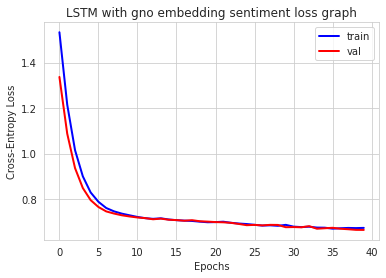

In [92]:
#generate plots
plt.figure()
plt.plot(lstm_no_embed_history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(lstm_no_embed_history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM with gno embedding sentiment loss graph')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [94]:
plt.figure()
plt.plot(lstm_no_embed_history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(lstm_no_embed_history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM with gno embedding sentiment accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [95]:
#prediction without embed
lst_predictions_noembed= lstm_no_embed.predict_classes(word_seq_test)
sample_lstm_noembed=pd.read_csv('test_dat.csv')
sample_lstm_noembed['pred']= (lst_predictions_noembed>=0.5).astype(int)

In [96]:
import sklearn
print("Accuracy Without Embedding in LSTM for twitter data :")
print(sklearn.metrics.accuracy_score(sample_lstm_noembed.target, sample_lstm_noembed.pred))

from sklearn import metrics
print(metrics.classification_report(sample_lstm_noembed.target, sample_lstm_noembed.pred))

Accuracy Without Embedding in LSTM for twitter data :
0.659881812212738
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       874
           1       0.62      0.52      0.56       649

    accuracy                           0.66      1523
   macro avg       0.65      0.64      0.64      1523
weighted avg       0.66      0.66      0.65      1523



In [97]:
keras.backend.clear_session()

In [98]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

3it [00:00, 22.05it/s]

loading word embeddings...


2000005it [01:51, 17866.03it/s]

found 1999997 word vectors


In [73]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 9168


In [74]:
print("sample words not found: ", np.random.choice(words_not_found, 10))


sample words not found:  ['bjrrqhhohl' 'ikfmektpcx' '4bcqzqjrzn' 'g891m9gh4r' 'hashd' 'detkenlang'
 'jwnxh9q5ov' 'avv6hpnpch' 'qkahxwlwxa' 'u7vavyrgv9']


In [75]:
from keras.layers import BatchNormalization
import tensorflow as tf


max_features =22248
#nb_words=22248
embedding_dim =16
sequence_length = 100

def model_with_embedding():
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    #embeddings_regularizer = regularizers.l2(0.005))) 
    model.add(tf.keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len,weights=[embedding_matrix],trainable=False))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
    model.add(tf.keras.layers.Dropout(0.4))


    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               
    return model

In [76]:
model_fasttext=model_with_embedding()

model_fasttext.summary()
model_fasttext.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           6674400   
_________________________________________________________________
dropout (Dropout)            (None, 21, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 16)            20288     
_________________________________________________________________
flatten (Flatten)            (None, 336)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               172544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [77]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_fasttext.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

history =model_fasttext.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 4263 samples, validate on 1827 samples
Epoch 1/40
4263/4263 [==============================] - 2s 380us/sample - loss: 1.5678 - acc: 0.5965 - val_loss: 1.3807 - val_acc: 0.6929
Epoch 2/40
4263/4263 [==============================] - 0s 114us/sample - loss: 1.2760 - acc: 0.7002 - val_loss: 1.1029 - val_acc: 0.7652
Epoch 3/40
4263/4263 [==============================] - 0s 107us/sample - loss: 1.0552 - acc: 0.7645 - val_loss: 0.9387 - val_acc: 0.7783
Epoch 4/40
4263/4263 [==============================] - 0s 107us/sample - loss: 0.9122 - acc: 0.7821 - val_loss: 0.8336 - val_acc: 0.7811
Epoch 5/40
4263/4263 [==============================] - 1s 122us/sample - loss: 0.8183 - acc: 0.7959 - val_loss: 0.7619 - val_acc: 0.7843
Epoch 6/40
4263/4263 [==============================] - 0s 111us/sample - loss: 0.7510 - acc: 0.8018 - val_loss: 0.7109 - val_acc: 0.7887
Epoch 7/40
4263/4263 [==============================] - 1s 125us/sample - loss: 0.7053 - acc: 0.8030 - val_loss: 0.6752 - va

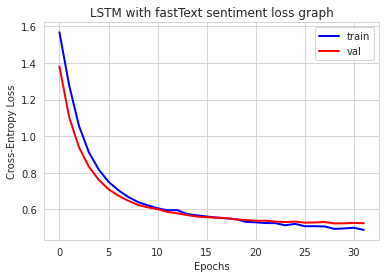

In [78]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM with fastText sentiment loss graph')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

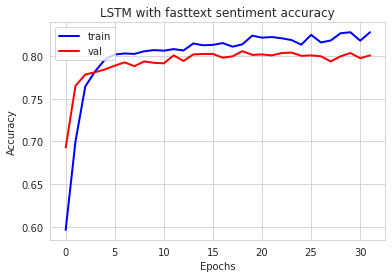

In [79]:
plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('LSTM with fasttext sentiment accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [80]:
predictions_lstm_fastext = model_gloVe.predict_classes(word_seq_test)
sample_lstm_fastext=pd.read_csv('test_dat.csv')
sample_lstm_fastext['pred']= (predictions_lstm_fastext>=0.5).astype(int)

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder_2:0", shape=(), dtype=float32) is not an element of this graph.

In [54]:

import sklearn
print("Accuracy With fasttext :")
print(sklearn.metrics.accuracy_score(sample_LSTMGLOVE.target, sample.pred))
from sklearn import metrics
print(metrics.classification_report(sample.target, sample.pred))

Accuracy With fasttext :
0.8207485226526592
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       874
           1       0.82      0.75      0.78       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



In [55]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('../glove.840B.300d.txt', encoding='utf-8')

loading word embeddings...


In [56]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 22248


In [57]:
from keras.layers import BatchNormalization
import tensorflow as tf


max_features =50000
#nb_words=22248
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    #embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len,weights=[embedding_matrix],trainable=False))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 21, 300)           6674400   
_________________________________________________________________
dropout_7 (Dropout)          (None, 21, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 16)            20288     
_________________________________________________________________
flatten_2 (Flatten)          (None, 336)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               172544    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                

In [58]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Train on 4263 samples, validate on 1827 samples
Epoch 1/40
4263/4263 [==============================] - 1s 301us/sample - loss: 1.5261 - acc: 0.5738 - val_loss: 1.3319 - val_acc: 0.5594
Epoch 2/40
4263/4263 [==============================] - 0s 111us/sample - loss: 1.2085 - acc: 0.5738 - val_loss: 1.0868 - val_acc: 0.5594
Epoch 3/40
4263/4263 [==============================] - 0s 109us/sample - loss: 1.0126 - acc: 0.5738 - val_loss: 0.9414 - val_acc: 0.5594
Epoch 4/40
4263/4263 [==============================] - 0s 107us/sample - loss: 0.8981 - acc: 0.5738 - val_loss: 0.8577 - val_acc: 0.5594
Epoch 5/40
4263/4263 [==============================] - 1s 119us/sample - loss: 0.8325 - acc: 0.5738 - val_loss: 0.8100 - val_acc: 0.5594
Epoch 6/40
4263/4263 [==============================] - 0s 113us/sample - loss: 0.7949 - acc: 0.5738 - val_loss: 0.7825 - val_acc: 0.5594
Epoch 7/40
4263/4263 [==============================] - 0s 111us/sample - loss: 0.7730 - acc: 0.5738 - val_loss: 0.7662 - va

In [60]:
predictions = model.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)

In [61]:
import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))
from sklearn import metrics
print(metrics.classification_report(sample.target, sample.pred))

Accuracy With GloVe :
0.5738673670387393
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       874
           1       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523



/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
